In [1]:
import gc
import os
import warnings
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
from keras.preprocessing.text import Tokenizer


pyLDAvis.enable_notebook()
np.random.seed(2018)
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [6]:
data_path = 'C:/Data/data/'
train = pd.read_csv(os.path.join(data_path , 'train.csv') , index_col='id')
test = pd.read_csv(os.path.join(data_path , 'test.csv') , index_col = 'id')

In [7]:
train.head(10)

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.000000,4,47
59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.009524,0,105
59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.220339,0,59
59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,...,26662,approved,0,0,0,0,0,0.000000,0,4


In [8]:
test.head()


,comment_text
id,
7000000,Jeff Sessions is another one of Trump's Orwell...
7000001,I actually inspected the infrastructure on Gra...
7000002,No it won't . That's just wishful thinking on ...
7000003,Instead of wringing our hands and nibbling the...
7000004,how many of you commenters have garbage piled ...


In [ ]:
print('Test and train shape : {} {}'.format(test.shape , train.shape))

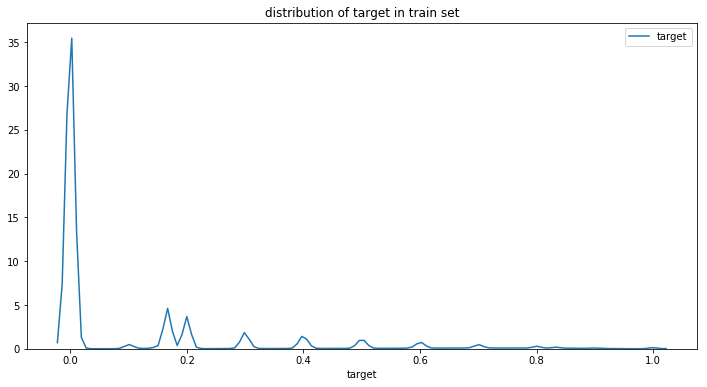

In [10]:
plt.figure(figsize = (12 , 6))
plt.title('distribution of target in train set')
sns.distplot(train['target'] , kde = True, hist = False, bins=120, label = 'target') #kde ?? bins??
plt.legend();plt.show()

By the plot we can see a total disbalance in our target classes

In [30]:
def plot_features_distribution(features , title = 'distribution of feature in train set'):
    plt.figure(figsize = (12 , 6))
    plt.title(title)
    for feature in features:
        sns.distplot(train.loc[~train[feature].isnull() , feature] , kde = True , hist = False , bins = 20 , label = feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

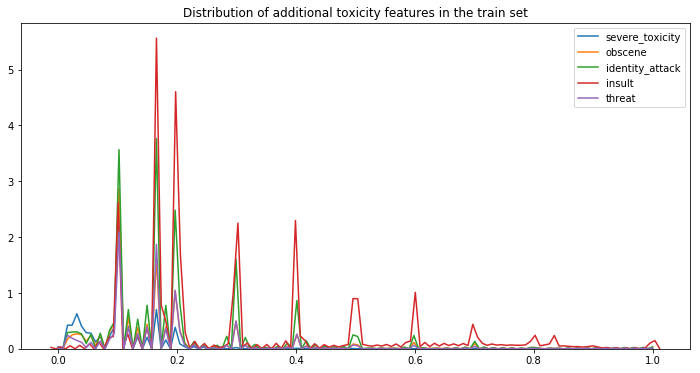

In [31]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set")

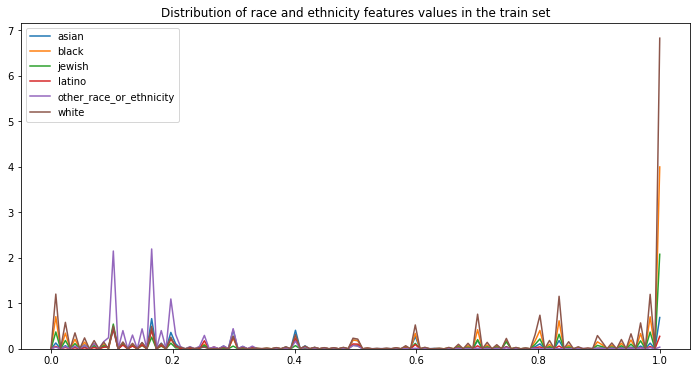

In [32]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set")

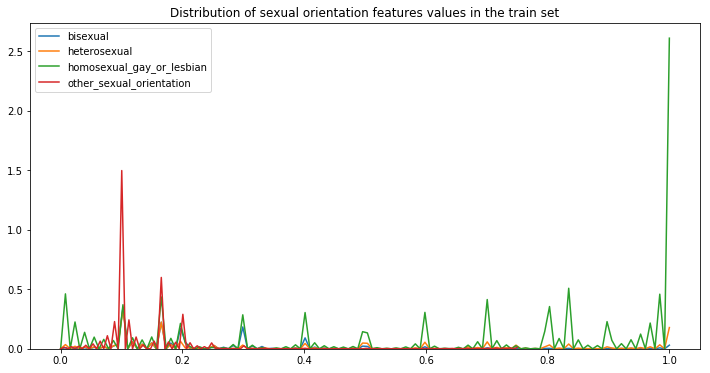

In [33]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set")

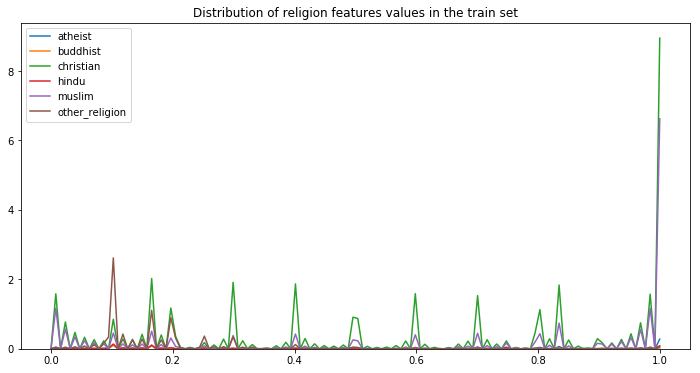

In [34]:
features = ['atheist','buddhist',  'christian', 'hindu', 'muslim', 'other_religion']
plot_features_distribution(features, "Distribution of religion features values in the train set")

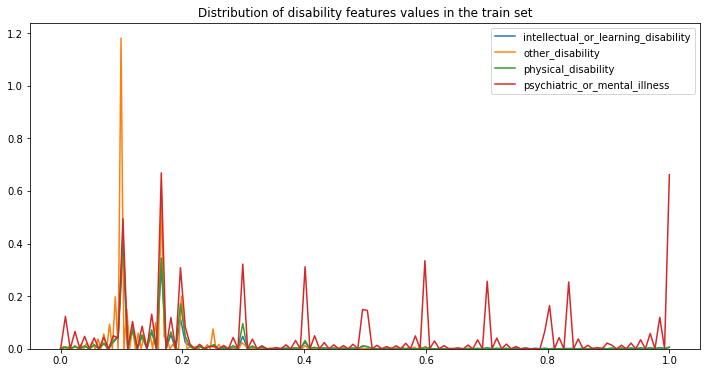

In [35]:
features = ['intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
plot_features_distribution(features, "Distribution of disability features values in the train set")

In [41]:
def plot_counts(feature , title , size = 1):
    f , ax = plt.subplots(1, 1, figsize = (4*size , 4))
    total =float(len(train))
    g = sns.countplot(train[feature], order = train[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()
    

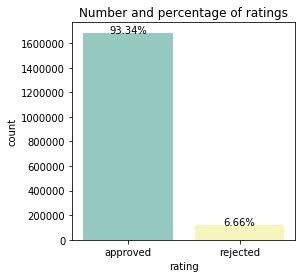

In [42]:
plot_counts('rating' , 'ratings')

In [47]:
stopwords = set(STOPWORDS)

def show_wordcloud(data , title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        max_words = 50,
        max_font_size = 40,
        scale = 5,
        random_state = 1
    ).generate(str(data))
    
    fig = plt.figure(1 , figsize = (10 , 10))
    plt.axis('off')
    if(title):
        fig.suptitle(title , fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    
    plt.imshow(wordcloud)
    plt.show()

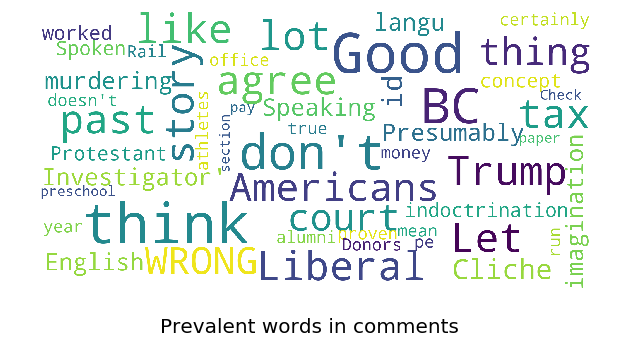

In [48]:
show_wordcloud(train['comment_text'].sample(1000) , title = "Prevalent words in comments")

In [55]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(token)
    return result

In [56]:
comment_sample = train['comment_text'][:1].values[0]

print(comment_sample)
print(preprocess(comment_sample))

This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!
['cool', 'like', 'want', 'mother', 'read', 'great', 'idea']


In [62]:
preprocessed_comments = train['comment_text'].sample(20000).map(preprocess)

In [64]:
preprocessed_comments.sample(3)

id
5119025    [dopers, careers, intellectual, capacity, matt...
938777     [voting, reform, promises, little, cheap, prop...
5290689    [want, lay, intolerance, trump, feet, tell, vi...
Name: comment_text, dtype: object

In [65]:
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below = 10 , no_above = 0.5 , keep_n  = 7500)

In [69]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [75]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf , num_topics = 20 , id2word = dictionary , passes=2 , workers = 2)

In [77]:
topics = lda_model.print_topics(num_words = 5)
for i , topic in enumerate(topics[:10]):
    print("Train topic {} : {}".format(i , topic))
    

Train topic 0 : (0, '0.004*"people" + 0.004*"church" + 0.003*"work" + 0.003*"dogs" + 0.003*"good"')
Train topic 1 : (1, '0.006*"weed" + 0.004*"yes" + 0.004*"russian" + 0.004*"warming" + 0.004*"check"')
Train topic 2 : (2, '0.008*"thank" + 0.004*"hate" + 0.004*"trump" + 0.004*"years" + 0.003*"people"')
Train topic 3 : (3, '0.004*"know" + 0.004*"trump" + 0.003*"time" + 0.003*"people" + 0.003*"like"')
Train topic 4 : (4, '0.006*"good" + 0.006*"trump" + 0.004*"point" + 0.003*"like" + 0.003*"law"')
Train topic 5 : (5, '0.004*"people" + 0.003*"like" + 0.003*"canada" + 0.003*"time" + 0.003*"going"')
Train topic 6 : (6, '0.006*"trump" + 0.004*"like" + 0.003*"right" + 0.003*"change" + 0.003*"cares"')
Train topic 7 : (7, '0.007*"trump" + 0.004*"thanks" + 0.004*"like" + 0.003*"obama" + 0.003*"love"')
Train topic 8 : (8, '0.007*"right" + 0.007*"comment" + 0.004*"people" + 0.004*"muslims" + 0.004*"news"')
Train topic 9 : (9, '0.005*"tax" + 0.004*"pay" + 0.004*"state" + 0.003*"income" + 0.003*"peopl

In [78]:
bd5 = bow_corpus[5]
for i in range(len(bd5)):
    print("Word {} (\"{}\") appears {} time.".format(bd5[i][0], dictionary[bd5[i][0]],bd5[i][1]))

Word 56 ("affect") appears 1 time.
Word 57 ("language") appears 1 time.
Word 58 ("people") appears 1 time.
Word 59 ("sign") appears 1 time.
Word 60 ("use") appears 1 time.


In [79]:
for index, score in sorted(lda_model[bd5], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.8416286706924438	 
Topic: 0.005*"com" + 0.004*"trump" + 0.004*"www" + 0.004*"right" + 0.003*"https"


Lets check the most important topic for each comment

In [85]:
def eval_topic(ldamodel = lda_model, corpus = bow_corpus, texts = preprocessed_comments):
    sent_topics_df = pd.DataFrame()
    
    for i , row in enumerate(ldamodel[corpus]):
        row = sorted(row , key = lambda x: (x[1]) , reverse = True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4),\
                                                                    topic_keywords]), ignore_index=True)
            else:
                break
    text = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, text], axis=1)
    return(sent_topics_df)
        

In [86]:
topic_sents_keywords = eval_topic(ldamodel=lda_model, corpus=bow_corpus, \
                                                  texts=preprocessed_comments)
dominant_topic =topic_sents_keywords.reset_index()
dominant_topic.columns = ['Comment', 'Dominant Topic', 'Topic Percent Contribution', 'Keywords','Text']
dominant_topic.head(5)

,Comment,Dominant Topic,Topic Percent Contribution,Keywords,Text
0,0,2.0,0.4405,"thank, hate, trump, years, people, awesome, fo...",NaN
1,1,6.0,0.4828,"trump, like, right, change, cares, funny, love...",NaN
2,2,2.0,0.5509,"thank, hate, trump, years, people, awesome, fo...",NaN
3,3,4.0,0.8268,"good, trump, point, like, law, people, know, c...",NaN
4,4,6.0,0.8416,"trump, like, right, change, cares, funny, love...",NaN
